# CIFAR-10 Image Classification - Training your own Convolutional Neural Network #
## EECS 16ML, Fall 2021 ##

Written by Richard Shuai, Dohyun Cheon, Larry Yan, Tony Shara, Adi Ganapathi. 

richardshuai@berkeley.edu, dohyuncheon@berkeley.edu, yanlarry@berkeley.edu, anthony.shara@berkeley.edu, avganapathi@berkeley.edu, 

### Table of contents ###
* [Introduction](#introduction)
* [Part 1: Introduction to Convolutions](#part1)  
◦ Implement the convolution operation  
◦ Visualize convolutions with different kernels  
* [Part 2: CIFAR-10 Image Classification](#part2)  
◦ Preprocess the dataset  
◦ Visualizing a basic CNN  
◦ Train your own model and plot learning curves
* [Part 3: Tricking a CNN Classifier with Adversarial Examples](#part3)  
◦ Generate an adversarial example  
◦ Classification of the adversarial example
* [Part 4: Implementing a Paper: ResNet](#part4)  
◦ Implement a residual block  
◦ Train a model using your residual block implementation
* [Conclusion and References](#conclusion)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from PIL import Image

from common_utils import *
import matplotlib.pyplot as plt

<a id="introduction"></a>
# Introduction

In this notebook, you will gain more familiarity with intuition about convolutional neural networks. You are also going to learn to classify images from the CIFAR-10 dataset with a simple convolutional neural network.
* First, we will review what a convolution by having you implement a convolution operation. We will then use this implementation to visualize convolutions with different kernels.
* Then, we will visualize the filters and activations in the network in order to gain an intuition about what the convolutional neural network is actually learning.
* You will then implement your own convolutional neural network for image classification.
* With this model, you will learn to generate adversarial examples to feed into your newly trained model.
* Finally, you will be required to read the ResNet paper and implement a residual block layer.

Note that training the models in this notebook may take awhile, so make sure to start early.

<a id="part1"></a>
# Part 1: Introduction to Convolutions

First, we will introduce the idea of convolutions and how they transform an image. 
On a 2D input image $I$ and using a kernel $G$ with width $w$ and height $h$, we can perform a discrete 2D-convolution that can be mathematically represented as:

$$
(I ∗ G)[x, y] = \sum_{k=1}^{w} \sum_{l=1}^{h} I[x + k, y + l]G[k, l]
$$
  
Visually, the convolution operation looks like this: ([source](https://mlnotebook.github.io/post/CNN1/))
<img src="./visuals/convSobel.gif" width=500 align="center"/>

Note that the convolution output dimensions depends on the dimensions of both the image and the kernel.    

In convolutional neural networks, the input image often has multiple channels, so our kernel will have multiple channels to match the input. We sum across the channels so that the convolution operation becomes:
$$
(I ∗ G)[x, y] = \sum_c \sum_{k=1}^{w} \sum_{l=1}^{h} I[x + k, y + l, c]G[k, l, c]
$$

Visually, the convolution will look like this: ([source](https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37))
<img src="./visuals/conv_multiple_channels.png" width=300 height=300/>

## Implement the convolution operation

In this section, we will demonstrate what different convolutional filters look like. In order to do so, you will need fill in the code below to implement a naive version of the convolution operation. Do not worry about efficiency for now.

In [2]:
def conv2d(X, kernel, stride=1, padding=(0, 0)):
    """
    Inputs:
     - X: Input image. Numpy array of shape (H, W, C).
     - kernel: Kernel. Numpy array of shape (H_k, W_k, C).
     - stride: Stride in both the y- and x-directions. Positive integer.
     - padding: Symmetric zero-padding specification for both the x- and y-directions. Tuple where padding[0]
                 and padding[1] specify padding in the y-direction and x-direction respectively.
    """
    # Expand for single channel dimension
    if X.ndim == 2:
        X = X[..., None]
    if kernel.ndim == 2:
        kernel = kernel[..., None]
    
    assert len(X.shape) == 3, 'Expected X to have 3 dimensions, but got shape {}'.format(X.shape)
    assert len(kernel.shape) == 3, 'Expected kernel to have 3 dimensions, but got shape {}'.format(kernel.shape)
    assert len(padding) == 2, 'Expected padding to be length 2, but got length {}'.format(len(padding))
    
    
    H, W, C = X.shape
    H_k, W_k, _ = kernel.shape
    pad_y, pad_x = padding
    
    out = None
    ### BEGIN CODE ###
    X_pad = np.pad(X, ((pad_y, pad_y), (pad_x, pad_x), (0, 0)))
    H_out = (H - H_k + 2*pad_y) // stride + 1
    W_out = (W - W_k + 2*pad_x) // stride + 1
    
    out = np.zeros((H_out, W_out))
    for l in range(H_out):
        for k in range(W_out):
            out[l, k] = np.sum(kernel * X_pad[l*stride:l*stride+H_k, k*stride:k*stride+W_k, :])
    ### END CODE ###
    
    return out

In [3]:
# Sanity checks for conv2d implementation
X = np.random.randint(0, 50, size=(7, 7, 1)).astype(np.float32)
K = np.random.randint(0, 5, size=(3, 3, 1)).astype(np.float32)

# With stride=1, padding=(0, 0)
conv_naive = conv2d(X, K)
conv_tf = tf.nn.conv2d(X[None], K[..., None], strides=1, padding='VALID').numpy().squeeze()
assert np.all(conv_naive == conv_tf)

# With stride=2, padding=(0, 0)
conv_naive = conv2d(X, K, stride=2)
conv_tf = tf.nn.conv2d(X[None], K[..., None], strides=2, padding='VALID').numpy().squeeze()
assert np.all(conv_naive == conv_tf)

# With stride=2, padding=(2, 3)
conv_naive = conv2d(X, K, stride=2, padding=(2, 3))
conv_tf = tf.nn.conv2d(X[None], K[..., None], strides=2, padding=((0, 0), (2, 2), (3, 3), (0, 0))).numpy().squeeze()
assert np.all(conv_naive == conv_tf)

## Visualize convolutions with different kernels 

### Kernels for Edge Detection

Now that we have defined the convolution operation, we will use this to visualize the effects of convolution with certain kernels. Here, we visualize the effects of convolving 4 different filters on the cameraman image:  

<img src="./visuals/camera_man.png" width=200 align="center"/>

The kernels that we will be visualizing are listed below.  
Identity Kernel:
$
\begin{bmatrix} 
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{bmatrix}
$  
Edge detection kernel 1:
$
\begin{bmatrix} 
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1 
\end{bmatrix}
$  
Edge detection kernel 2:
$
\begin{bmatrix} 
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 
\end{bmatrix}
$  
Edge detection kernel 3:
$
\begin{bmatrix} 
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1 
\end{bmatrix}
$  

In [4]:
img = np.asarray(Image.open('./visuals/camera_man.png'))

kernels = np.array([[[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]],
                    
                [[-1, -1, -1],
                [0, 0, 0],
                [1, 1, 1]],
                
                [[-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]],
                
                [[-1, -1, -1],
                [-1, 8, -1],
                [-1, -1, -1]]
])

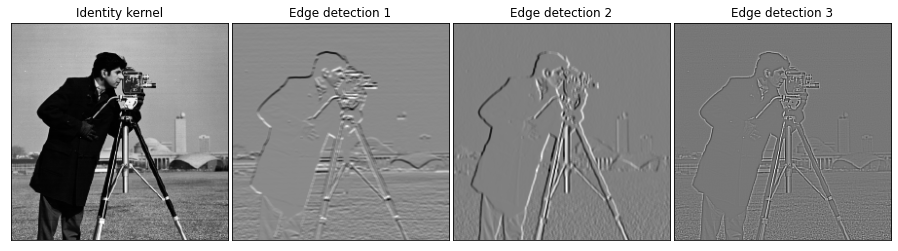

In [5]:
convolved_imgs = []
labels = ['Identity kernel', 'Edge detection 1', 'Edge detection 2', 'Edge detection 3']

for i, kernel in enumerate(kernels):
    convolved_img = conv2d(img, kernel)
    convolved_imgs.append(convolved_img)
    
plot_labeled_image_grid(np.array(convolved_imgs), labels, cmap='gray', sizes=4, n_cols=4)

**Describe what you notice about the different convolution outputs. How do the edge detection kernels differ?**

**Your answer: <span style="color:blue"> The identity kernel returns the original image. The first edge detection kernel seems to recognize horizontal edges well, while the second edge detection kernel recognizes vertical edges better. This difference is especially clear when looking at the floor or the camera stand. Finally, the third edge detection kernel recognizes edges without biasing particularly towards any direction. This makes sense, since the kernel itself is completely symmetric about the center. </span>**

### Gaussian blurring

As a quick demonstration, beyond just edge detection, convolving images with a kernel can also achieve a blurring effect. Here, we apply a Gaussian blur by convolving a certain matrix over the image. This matrix is based on the probability density function for a 2D Gaussian distribution with mean $0$ and standard deviation $\sigma$:  

$$ f(x, y) = \frac{1}{2\pi \sigma^2}e^{-\frac{x^2 + y^2}{2\sigma^2}}$$.  
A kernel is obtained from this density function by integrating over each pixel. Doing this with $\sigma=1$ for a  5x5 yields this discrete approximation:  

$$ \frac{1}{256} 
\begin{bmatrix} 
1 & 4 & 6 & 4 & 1 \\
4 & 16 & 24 & 16 & 4 \\ 
6 & 24 & 36 & 24 & 6 \\
4 & 16 & 24 & 16 & 4 \\
1 & 4 & 6 & 4 & 1
\end{bmatrix}
$$


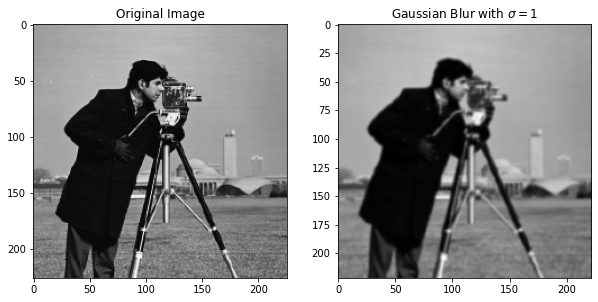

In [6]:
gaussian_kernel = np.array([[1, 4, 6, 4, 1],
                            [4, 16, 24, 16, 4], 
                            [6, 24, 36, 24, 6],
                            [4, 16, 24, 16, 4],
                            [1, 4, 6, 4, 1]]) / 256

# Blurred image
blurred_img = conv2d(img, gaussian_kernel)

# Plot images side by side
fig = plt.figure(figsize=(10, 5))
s1 = fig.add_subplot(1, 2, 1)
s1.set_title(r'Original Image')
plt.imshow(img, cmap='gray')

s2 = fig.add_subplot(1, 2, 2)
s2.set_title(r'Gaussian Blur with $\sigma=1$')
plt.imshow(blurred_img, cmap='gray')
plt.show()

<a id="part2"></a>

# Part 2: CIFAR-10 Image Classification

Now that we have a better understanding of how convolutions work and how they transform images, we will learn how to use a convolutional neural network to extract features from an image and perform image classification on CIFAR-10.

## Preprocess the dataset

### Load in the CIFAR-10 Dataset

In [7]:
(X, Y), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

### Visualize a few images from the dataset

First, we'll plot some of the images to understand what we're actually classifying. The possible classes are given in the label_names array. Feel free to change num_visualize to see more images.

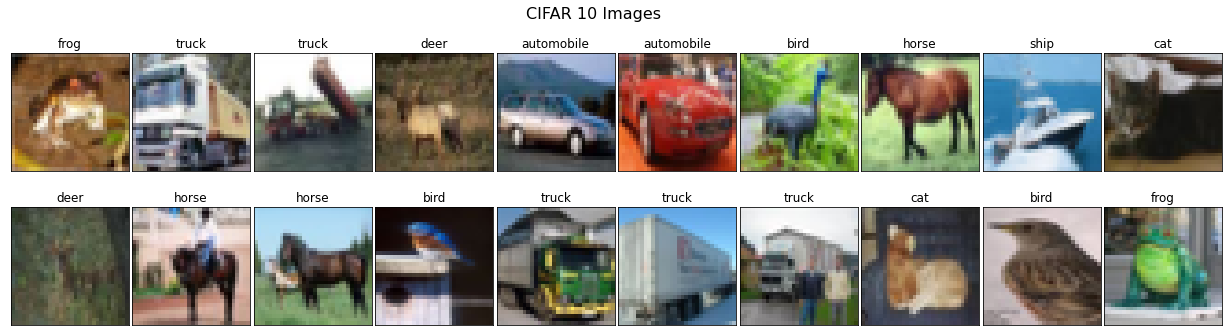

In [8]:
label_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Input the number of images to visualize
num_visualize = 20

# Construct a grid to plot images
labels = label_names[Y[:num_visualize].squeeze()] # Get label names in English from their 0-9 encodings
plot_labeled_image_grid(X[:num_visualize], labels, title='CIFAR 10 Images')

Note that the images from the CIFAR-10 dataset are unfortunately low resolution because each image is only 32x32 pixels. These images are small to help us focus on the classification task without worrying too much about computing power. 

### Create Train, Validation, and Test Datasets

Fill in the code to split the dataset into train and validation sets. Here, we will use a 90:10 split to create our train and validation datasets.

In [9]:
TRAIN_SPLIT = 0.9
NUM_TRAIN_SAMPLES = int(TRAIN_SPLIT * X.shape[0])

In [10]:
def train_val_split(X, Y, num_train_samples):
    N = X.shape[0]

    ### BEGIN CODE ###
    mask = np.zeros(N, dtype=np.bool)
    val_indices = np.random.choice(N, num_train_samples, replace=False)
    mask[val_indices] = True

    X_train = X[mask]    
    X_val = X[~mask]
    
    Y_train = Y[mask]
    Y_val = Y[~mask]
    ### END CODE ###

    return X_train, Y_train, X_val, Y_val

In [11]:
# Split dataset with our function
X_train, Y_train, X_val, Y_val = train_val_split(X, Y, NUM_TRAIN_SAMPLES)

In [12]:
# Sanity check for shapes
assert(X_train.shape == (45000, 32, 32, 3))
assert(X_val.shape == (5000, 32, 32, 3))
assert(Y_train.shape == (45000, 1))
assert(Y_val.shape == (5000, 1))

### Image Preprocessing

Preprocess the images in our dataset. There are several ways you can do this. We have provided some examples below.
* Normalize the data from 0 to 1. 
* Subtract the mean of the training data
* Z-score standardization
* Dividing by 255 (for images ranging from 0 to 255)

Remember to apply the same preprocessing to the test and validation datasets as you do the train datasets. (For example, if the mean is calculated across the training data, subtract that same value from the validation and test sets).

In [13]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

### BEGIN CODE ###
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0
### END CODE ###

## Visualizing a basic CNN

In this section, we define and train a basic CNN and visualize the learned filters from the first layer as well as layer activations when classifying images.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=9, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])

For this classification task, we use categorical cross entropy loss. In Keras, since our data is not one-hot encoded, we use sparse categorical cross entropy loss, but this is equivalent to categorical cross entropy loss for one-hot encoded labels. This loss for each sample is defined as: 
$$L(x) = \displaystyle\sum_{k=1}^C -y_{k} \cdot log(\sigma(s)_k)$$

* $y_k = 1$ if the sample belongs to class $k$ and $y_k = 0$ is it does not belong to class $k$.
* $s$ is the score obtained from the last layer of the network before the activation function.
* $\sigma$ is the softmax activation function:
$$\sigma(z)_k = \frac{e^{z_k}}{\sum_{j=1}^{C} e^{z_j}}$$  

The loss is therefore
$$Loss = \frac{1}{N} \displaystyle\sum_{i=1}^{N} \displaystyle\sum_{k=1}^C -y_{i, k} \cdot log(\sigma(s_i)_k) $$  

where we average over the batch with batch size $N$.  

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

We now compile and view a summary of our model. We can observe that most of the weights in our model come from the fully connected layers at the end.

In [16]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0

In [17]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 2.2279 - accuracy: 0.2267 - val_loss: 2.1821 - val_accuracy: 0.2716
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 2.0606 - accuracy: 0.3952 - val_loss: 2.0251 - val_accuracy: 0.4332
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 2.0097 - accuracy: 0.4464 - val_loss: 1.9980 - val_accuracy: 0.4556
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.9707 - accuracy: 0.4865 - val_loss: 1.9480 - val_accuracy: 0.5082
Epoch 5/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.9208 - accuracy: 0.5380 - val_loss: 1.9438 - val_accuracy: 0.5144
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8937 - accuracy: 0.5654 - val_loss: 1.9290 - val_accuracy: 0.5272
Epoch 7/10
1407/1407 [==============================] - 6s 5ms/step - loss: 1.8740 - accuracy: 0.5854 - val_loss: 1.9755 - val_accuracy:

### Visualize learned filters

With this model, we can visualize the filters from the first convolutional layer to see what features the filters are detecting. As you should see, some of these filters look like edge-detecting filters.   
Note that here, we only extract the filters from the first convolutional layer because it is generally more difficult to interpret the convolutional filters from deeper layers. This is because these deeper layers act on encoded representations of images.

In [18]:
def normalize(x):
    a = np.min(x)
    b = np.max(x)
    return (x - a) / (b - a)

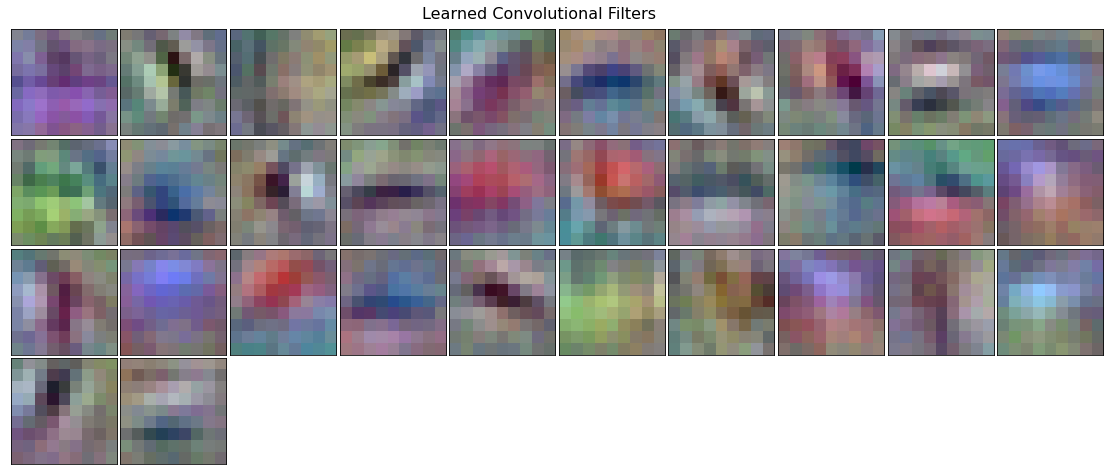

In [19]:
# Get the layers of the model in a list
layers = model.layers

# Extract the filters from the first convolutional layer
layer_0 = layers[0]
filters, biases = layer_0.get_weights()
filters = normalize(filters)

plot_image_grid(filters.transpose(3, 0, 1, 2), title='Learned Convolutional Filters')

**Do any of these filters appear meaningful or recognizable?** *(Hint: you may recognize some filters from earlier in this notebook)*

**Your answer: <span style="color:blue">Some filters appear to be detecting edges or features -- we can even see filters that look similar to our edge detecting filters from above. Furthermore, the variety of filter colors demonstrate responses to different colors. </span>**

### Visualize activations for certain images

We can also visualize the activations from the network when it makes predictions on certain images. This helps us understand how each filter encodes the image and transforms it through successive convolutional layers. Here, we demonstrate a visualization for the first layer activations. Fill in the code to visualize activations from the second and third convolutional layers. 

Hint: Insepct model.layers in order to understand the outputs of the activation_model.

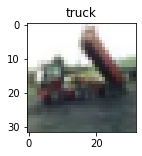

In [20]:
k = 2 # Change k to visualize different images in the training dataset.

img = X_train[k]
label = label_names[Y_train[k].squeeze()]

fig = plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.title(label)
plt.show()

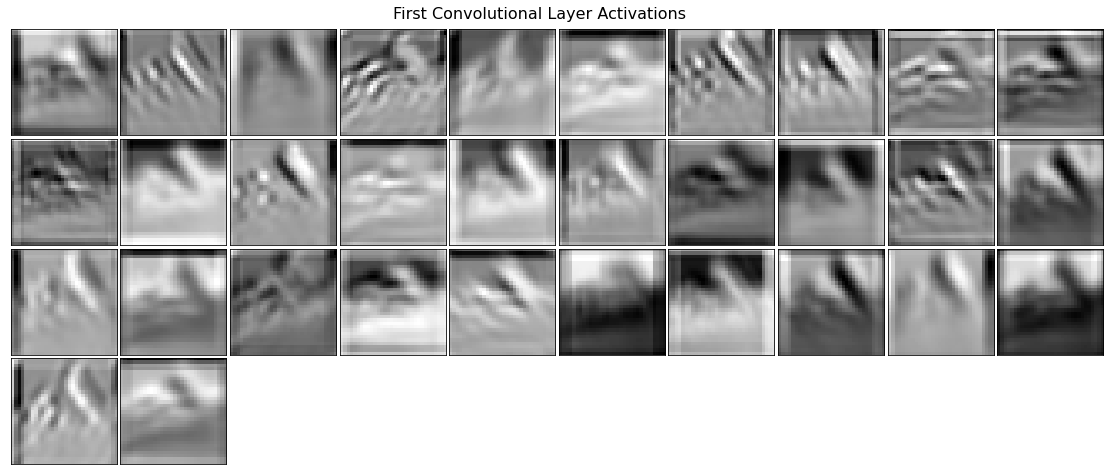

In [21]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(model.input, layer_outputs)
activations = activation_model(img[np.newaxis, ...])

first_conv_activations = activations[0]

plot_image_grid(tf.squeeze(tf.transpose(first_conv_activations, [3, 0, 1, 2])), title='First Convolutional Layer Activations')

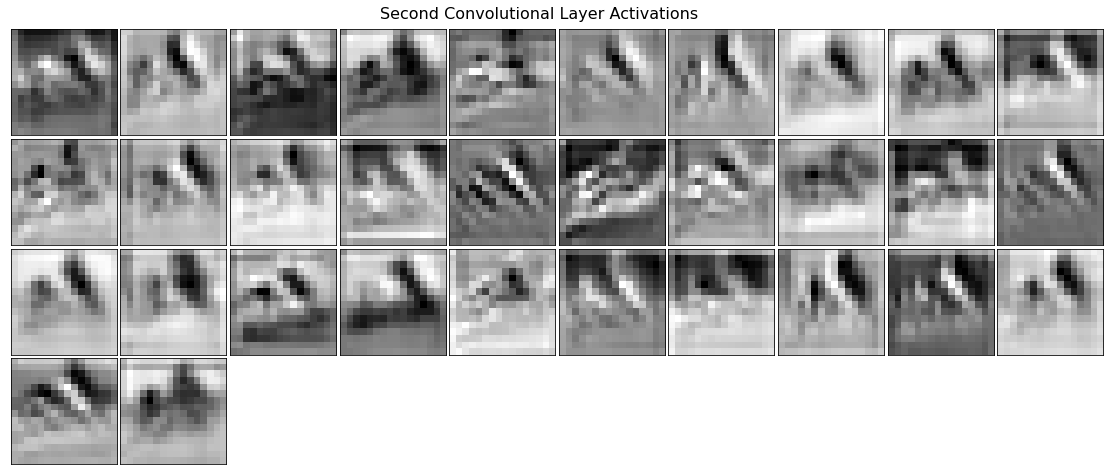

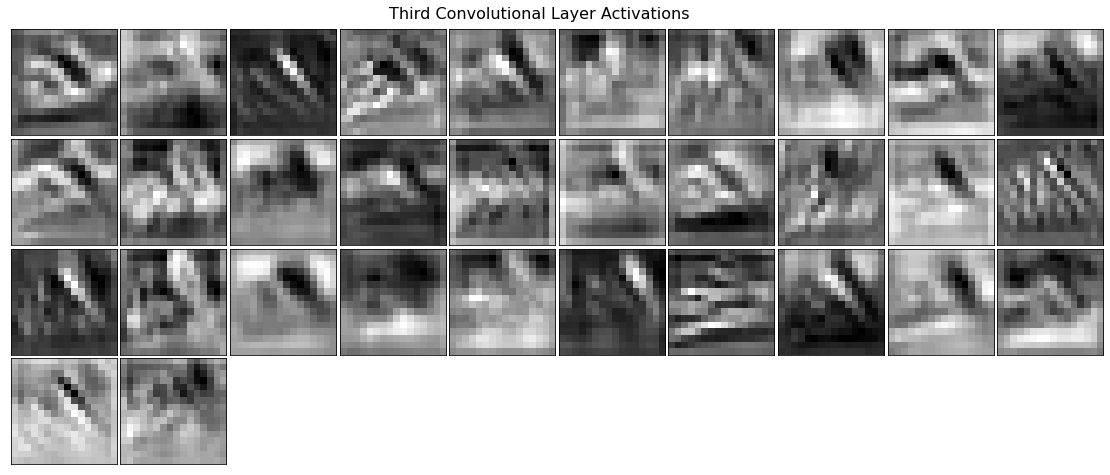

In [22]:
second_conv_activations = None
third_conv_activations = None

### BEGIN CODE ###
second_conv_activations = activations[4]
third_conv_activations = activations[8]
### END CODE ###

plot_image_grid(tf.squeeze(tf.transpose(second_conv_activations, [3, 0, 1, 2])), title='Second Convolutional Layer Activations')
plot_image_grid(tf.squeeze(tf.transpose(third_conv_activations, [3, 0, 1, 2])), title='Third Convolutional Layer Activations')

**Describe what you notice about the activations. How is the image transformed over successive layers?**

**Your answer: <span style="color:blue">The activations from the first convolutional layer preserve a lot of the original image, and this layer seems to be extracting features from the image. As we look at the activations from deeper convolutional layers, we can still recognize some features, but the activations become less interpretable. Intuitively, this is because the filters start to encode and extract the necessary information it needs to make its classification. </span>**

## Train Your Own Model

Now that we've developed a better intuitive understanding of how convolutional neural networks learn, it's time for you to implement a better architecture that can achieve a higher validation loss. Train a model to achieve a validation loss of at least 70% on CIFAR-10. 

Some tricks that might be helpful:
* Common kernel sizes are 3x3 or 5x5. Remember that larger kernel sizes can require a much larger number of parameters.
* Batch normalization can vastly speed up training by rescaling the inputs to each layer. It can also be act to regularize your network. You can read more about it here: https://arxiv.org/abs/1502.03167
* Architectures commonly make use of a CONV -> BATCH_NORM -> ACTIVATION -> CONV -> BATCH_NORM -> ACTIVATION -> POOLING pattern.
* Other ideas to test out include changing hyperparameters such as stride, adding dropout layers, and different optimization algorithms (https://ruder.io/optimizing-gradient-descent/).

You are given a lot of freedom to write the code for your architecture. Feel free to change any starter code if you feel like it's necessary.

In [23]:
model = None

### BEGIN CODE ###
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])
## END CODE ###

In [24]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)       

In [25]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Epoch 1/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.9662 - accuracy: 0.4912 - val_loss: 1.9004 - val_accuracy: 0.5584
Epoch 2/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8203 - accuracy: 0.6411 - val_loss: 1.8708 - val_accuracy: 0.5854
Epoch 3/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7657 - accuracy: 0.6977 - val_loss: 1.8483 - val_accuracy: 0.6116
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7296 - accuracy: 0.7335 - val_loss: 1.8298 - val_accuracy: 0.6276
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7030 - accuracy: 0.7602 - val_loss: 1.7200 - val_accuracy: 0.7414
Epoch 6/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6776 - accuracy: 0.7864 - val_loss: 1.8199 - val_accuracy: 0.6422
Epoch 7/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6581 - accuracy: 0.8056 - val_loss: 1.7191 - val_accuracy

### Visualize the learning curves

Plot the train loss and validation loss as a function of the number of epochs trained.

*(Hint: the history returned from model.fit may be helpful here.)*

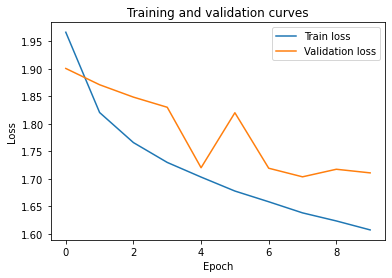

In [26]:
### BEGIN CODE ###
plt.title('Training and validation curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])
plt.show()
### END CODE ###

### Report the final loss on our test set

We now evaluate the model on the test set to get the final test accuracy for the model. Note that we only evaluate on the test set once, at the end.

In [27]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Final test set accuracy: {}'.format(accuracy))

313/313 [==============================] - 1s 2ms/step - loss: 1.7115 - accuracy: 0.7493
Final test set accuracy: 0.7493000030517578


<a id="part3"></a>

# Part 3: Tricking a CNN Classifier with Adversarial Examples

As we have seen, CNNs are capable of classifying images with high accuracy. However, it turns out that it is very easy to "trick" a trained CNN classifier with *adversarial examples*. By taking a correctly classified image and adding a small but directed perturbation to the image, we can force the CNN to misclassify the image with high confidence. In this section, we will briefly demonstrate how we can cause your newly trained model to misclassify images with methods based on this paper: https://arxiv.org/abs/1412.6572. 

The change that we will be making is as follows:
$$\vec{x}_{adversarial} = \vec{x} + \epsilon \cdot sign(\nabla_x J(\theta, \vec{x}, y))$$  
where $J(\theta, \vec{x}, y))$ is the loss resulting from evaluating the model on an input image $\vec{x}$ with model parameters $\theta$, and $\epsilon$ is a small constant. Notice that we are taking the gradient with respect to the input image $x$ this time. Intuitively, this means that we are changing the image by making a small step in the direction that maximizes the loss the most under a max-norm constraint.

Fill in the code below to implement this update. You will need to compute the gradient of the loss with respect to the model input and set it to grad_x.  
*(Hint: [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) may be helpful here)*

## Generate an adversarial example

In [28]:
def generate_adversarial_example(model, x, y_true, eps=0.01):
    if len(x.shape) == 3:
        x = x[np.newaxis, ...]

    x = tf.convert_to_tensor(x, dtype=tf.float32)
    
    grad_x = None
    adversarial_example = None

    ### BEGIN CODE ###
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    grad_x = tape.gradient(loss, x)
    
    adversarial_example = x + eps*np.sign(grad_x)
    ### END CODE ### 
    
    return (grad_x, adversarial_example)

For the purpose of our example, we want to make sure we perturb an image that the model would ordinarily be able to correctly classify. Obtain the index of such a correctly classified image in X_train and set it to variable idx.

In [29]:
idx = None

### BEGIN CODE ###
Y_preds = model.predict(X_train)
correct_indices = np.where(np.argmax(Y_preds, axis=1) == Y_train.squeeze())[0]
idx = np.random.choice(correct_indices)
### END CODE ###

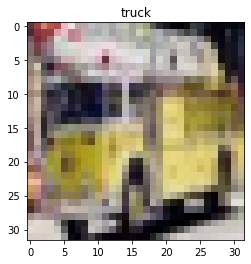

In [30]:
# Visualize the original image and your model's prediction
img = X_train[idx]
y_true = Y_train[idx].squeeze()

plt.title(label_names[y_true])
plt.imshow(img)
plt.show()

With this correctly classified image, fill in the code below to generate an adversarial example that your model is likely to misclassify.

In [31]:
eps = 0.01
grad_x = None
adversarial_img = None

### BEGIN CODE ###
grad_x, adversarial_img = generate_adversarial_example(model, img, y_true, eps=eps)
### END CODE ###

## Classification of the adversarial example

Run the forward pass of the model to find the prediction it makes on the adversarial input and set the label to label_new. You may need to slightly tune $\epsilon$ from above or change the original image in order to misclassify the image.

In [32]:
label_new = None

### BEGIN CODE ###
y_preds_adversarial = model(adversarial_img)
label_new = label_names[np.argmax(y_preds_adversarial)]
### END CODE ###

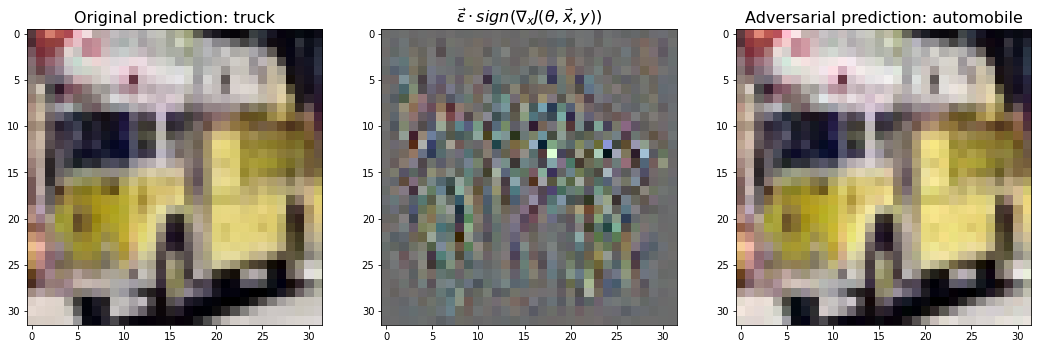

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.set_title('Original prediction: {}'.format(label_names[y_true]), fontsize=16)
ax1.imshow(img)

ax2.set_title(r'$\vec{\epsilon} \cdot sign(\nabla_x J(\theta, \vec{x}, y))$', fontsize=16)
ax2.imshow(normalize(tf.squeeze(grad_x)))

ax3.set_title('Adversarial prediction: {}'.format(label_new), fontsize=16)
ax3.imshow(normalize(tf.squeeze(adversarial_img)))

plt.show()


You can see that the two images look identical to the human eye. This demonstrates that although CNNs appear to classify images in a very intuitive way by extracting recognizable features, the model can still fail to classify images that are perturbed in a certain way.

<a id="part4"></a>
# Part 4: Implementing a Paper: ResNet

### Implement a residual block

In developing machine learning models, it is valuable practice to be able to read a paper, understand it conceptually, and then to actually implement its architecture. Here, we will implement a key component of the architecture from the ResNet paper: residual blocks. 

Read through the ResNet paper, and then fill in the code to implement a residual block with two layers.  
The ResNet paper can be found here: https://arxiv.org/abs/1512.03385

Below, we've included a diagram from the picture for what specifically you should implement: use convolutional layers for the weight layers, and if the dimensions of $\vec{x}$ and $\mathcal{F}$ do not match, use a 1x1 convolution as the linear projection to match the dimensions.  


<img src="visuals/resnet_building_block.png" alt="Drawing" style="width: 50em;"/>

**What is the intuition behind using residual blocks in a neural network? Why are they useful?**

**Your answer: <span style="color:blue"> These residual blocks can improve model accuracy and speed up training especially in deeper neural networks. By including a shortcut connection, it becomes easier for the network to learn an optimal function starting with the identity than completely from scratch. </span>**

In [34]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        ### BEGIN CODE ###
        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.ReLU()
        
        self.skip = None
        if in_channels != out_channels:
            self.skip = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(out_channels, kernel_size=1, padding='same'),
                tf.keras.layers.BatchNormalization()
            ])
        ### END CODE ###
        
    def call(self, x):
        ### BEGIN CODE ###
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip:
            x = self.skip(x)
        out = out + x
        out = self.act2(out)
        ### END CODE ###
        return out

In [35]:
### Sanity checking for the shapes of your outputs ###
x = tf.random.uniform([1, 5, 5, 3])

residual_block_1 = ResidualBlock(in_channels=3, out_channels=3, kernel_size=3)
residual_block_2 = ResidualBlock(in_channels=3, out_channels=7, kernel_size=3)

assert tuple(tf.shape(residual_block_1(x))) == (1, 5, 5, 3)
assert tuple(tf.shape(residual_block_2(x))) == (1, 5, 5, 7)

### Train a model using your residual block implementation

Here, you can test your residual block implementation by directly using it to train a model. As you implement your model, you should keep in mind that residual blocks tend to shine the most in deeper networks.    

Again, we have provided starter code for the loss function and fitting, but feel free to change the code if you need to. Achieve a validation accuracy of over 70%, but do not worry about outperforming the model you trained previously.

In [36]:
model = None

### BEGIN CODE ###
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    ResidualBlock(32, 32, kernel_size=3),
    ResidualBlock(32, 32, kernel_size=3),
    ResidualBlock(32, 32, kernel_size=3),
    ResidualBlock(32, 32, kernel_size=3),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    ResidualBlock(32, 64, kernel_size=3),
    ResidualBlock(64, 64, kernel_size=3),
    ResidualBlock(64, 64, kernel_size=3),
    ResidualBlock(64, 64, kernel_size=3),
    ResidualBlock(64, 64, kernel_size=3),
    ResidualBlock(64, 64, kernel_size=3),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])
## END CODE ###

In [37]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
residual_block_2 (ResidualBl (None, 32, 32, 32)        18752     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 32, 32, 32)        18752     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 32, 32, 32)        18752     
_________________________________________________________________
residual_block_5 (ResidualBl (None, 32, 32, 32)       

In [38]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Epoch 1/10
1407/1407 [==============================] - 20s 14ms/step - loss: 1.9896 - accuracy: 0.4713 - val_loss: 1.9131 - val_accuracy: 0.5508
Epoch 2/10
1407/1407 [==============================] - 20s 14ms/step - loss: 1.8252 - accuracy: 0.6389 - val_loss: 1.8557 - val_accuracy: 0.6060
Epoch 3/10
1407/1407 [==============================] - 22s 16ms/step - loss: 1.7637 - accuracy: 0.6996 - val_loss: 1.7805 - val_accuracy: 0.6796
Epoch 4/10
1407/1407 [==============================] - 22s 16ms/step - loss: 1.7257 - accuracy: 0.7377 - val_loss: 1.7411 - val_accuracy: 0.7214
Epoch 5/10
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6950 - accuracy: 0.7693 - val_loss: 1.7633 - val_accuracy: 0.6976
Epoch 6/10
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6646 - accuracy: 0.7992 - val_loss: 1.7120 - val_accuracy: 0.7502
Epoch 7/10
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6413 - accuracy: 0.8237 - val_loss: 1.7212 -

### Report your final loss on the test set

In [39]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Final test set accuracy: {}'.format(accuracy))

313/313 [==============================] - 1s 5ms/step - loss: 1.7051 - accuracy: 0.7559
Final test set accuracy: 0.7559000253677368


<a id="conclusion"></a>
# Conclusion
Great job! You've implemented a convolutional layers and successfully built your own CNN to classify images, learning how you can visualize the filters and activations of a trained model along the way. You also saw a bit about how small but selective perturbations can cause your CNN to misclassify relatively easily. Finally, you were able to practice reading and implementing a machine learning research paper. 

# References
Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (Sergey Ioffe, Christian Szegedy)  
https://arxiv.org/abs/1502.03167

An overview of gradient descent optimization algorithms (Sebastian Ruder)  
https://ruder.io/optimizing-gradient-descent/


Explaining and Harnessing Adversarial Examples (Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy)  
https://arxiv.org/abs/1412.6572

Deep Residual Learning for Image Recognition (Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun)  
https://arxiv.org/abs/1512.03385